In [1]:
from sympy.physics.mechanics import dynamicsymbols, inertia
import sympy as sp, numpy as np
import sympy.physics.vector as vector
from sympy.algebras.quaternion import Quaternion
from sympy.utilities.lambdify import lambdastr
from sympy import symbols
import sys, os

sys.path.append(os.path.expanduser('~/projects/sympy_fixes'))
import sympy_fixes

sp.init_printing(latex_printer=sympy_fixes.fixed_gamma_latex)

In [2]:
t = dynamicsymbols._t # time symbol

omega_p, a, f, e = kinematics_parameters = symbols('omega_p a f e') # planet angular velocity, semi-major axis length, flattening ratio, eccentricity
e_squared = 1-(1-f)**2 # planet eccentricity
# since f = 1 - (b/a) and b <= a, we actually have f in 

lamda_I, lamda_E, phi_E, h, phi_C, r_p, rho_M, rho_V = dynamicsymbols('lamda_I lamda_E phi_E h phi_C r_p rho_M rho_V') 
# inertial longitude (lamda_E = lamda_I - omega_p*t)
# geodetic longitude, geodetic latitude, geodetic altitude (note, geo |-> planeto to genearalize)
# geocentric latitude, geocentric radius to point on surface
# radius of curvature (in prime meridian), radius of curvature in prime vertical

psi, theta, phi = dynamicsymbols('psi theta phi') # euler angles local to body : yaw pitch roll

# planet-based reference frames
I = vector.frame.ReferenceFrame('I') # earth centered Inertial
G = I.orientnew('G', 'Body', [omega_p*t, 0, 0], '321') # earth centered, earth Fixed 
# this G only shows rotation, but could also show nutation and procession 
NED = G.orientnew('NED', 'Body', [lamda_E, -phi_E-sp.pi/2, 0], '321') # local/NED on planet surface
C = NED.orientnew('C', 'Body', [phi_E-phi_C, 0, 0], '213')
# C_NESC = M.orientnew('C', 'Body', [0, -phi_C-sp.pi/2, 0], '321')
# points C.z to planet center from point P on surface of oblate spheroid directly below object O

V_N, V_E, V_D = V_NED = sp.Array(
    # relative velocity in local frame (NED) -- add winds to get aero
    dynamicsymbols('V_N V_E V_D')
)

# expression for radii of curvature in terms of detic latitue
rho_M_expr_phi_E = a*(1-e**2)/sp.sqrt(1-e**2*sp.sin(phi_E)**2)**(3)
rho_V_expr_phi_E = a/sp.sqrt(1-e**2*sp.sin(phi_E)**2)

# kinematic expressions for geodetic lat and long from NESC; not sure if needed
phi_E_dot_expr = V_N/(rho_M+h)
lamda_E_dot_expr = V_E/((rho_V + h)*sp.cos(phi_E))

I0 = vector.Point('I_0') # planet center
I0.set_vel(I, 0)
I0.set_acc(I, 0)

I0.set_vel(G, 0)
I0.set_acc(G, 0)

# I0.set_vel(M, 0)
# I0.set_acc(M, 0)


# inertial position, velocity, and acceleration of vehicle center of mass
# expressed in ECI frame
px, py, pz = inertial_pos_I = sp.Array(dynamicsymbols('p_x p_y p_z'))
vx, vy, vz = inertial_vel_I = sp.Array(dynamicsymbols('v_x v_y v_z'))
ax, ay, az = inertial_acc_I = sp.Array(dynamicsymbols('a_x a_y a_z'))

inertial_pos_I_deriv_dict = sp.solve(inertial_pos_I.diff(t) - inertial_vel_I, inertial_pos_I.diff(t))


B_cm = vector.Point('B_cm') # center of mass of vehicle body B
B_cm.set_pos(I0, px*I.x + py*I.y + pz*I.z)
B_cm.set_vel(I, vx*I.x + vy*I.y + vz*I.z)
B_cm.set_acc(I, ax*I.x + ay*I.y + az*I.z)

# symbolic placeholder for geocentric rectangular coordinates to geodetic polar coordinates 
# transformation function
gc2gd = symbols('gc2gd', cls=sp.Function)(px, py, pz)
gc2gd.shape = (3,)

gd2gc = symbols('gd2gc', cls=sp.Function)(lamda_E, phi_E, h)
gd2gc.shape = (3,)


# placeholder functions for calling (potentially perturbable) atmospheric functions
planet_fixed_position_x, planet_fixed_position_y, planet_fixed_position_z = planet_fixed_position = sp.Array(
    dynamicsymbols('ap_x ap_y ap_z') # lat, long, altitude if not flat, p_x, p_y, p_z if flat
)
planet_fixed_func_args = (t, planet_fixed_position_x, planet_fixed_position_y, planet_fixed_position_z)

# function for acceleration due to gravity 
# TODO: check if this should actually be a function of planet fixed
# I believe this can capture common translational acceleration -- Well, DOESN'T CAPTURE FLAT! lol.
# hopefully it captures all other common translational acceleration due to gravity.
# should suffice for NESC's spherical and harmonic
# TODO: consider a switch so it's just in the N.z direction if flat

gravity_func = sp.symbols('gravity', cls=sp.Function)(px, py, pz)
gravity_func.shape = (3,)
#J Hill says 84-WGS gravity is standard, 18? term spherical
gx, gy, gz = g = sp.Array(dynamicsymbols('g_x g_y g_z'))
translation_acceleration_due_to_gravity = gx*I.x + gy*I.y + gz*I.z


# atmospheric functions for density and wind
density, speed_of_sound, viscosity = dynamicsymbols('rho c_s mu')

winds_func = sp.symbols('winds', cls=sp.Function)(*planet_fixed_func_args)
winds_func.shape = (3,)
W_N, W_E, W_D = W_NED = sp.Array(
    dynamicsymbols('W_N W_E W_D')
)

density_func = symbols('density', cls=sp.Function)(*planet_fixed_func_args)
speed_of_sound_func = symbols('speed_of_sound', cls=sp.Function)(*planet_fixed_func_args)
viscosity_func = symbols('viscosity', cls=sp.Function)(*planet_fixed_func_args)


# non-unit quaternion component symbols to represent I to body B attitude
q = sp.Array(
    dynamicsymbols('q_0:4') 
)
qmag = sp.sqrt(sp.tensorcontraction(sp.tensorproduct(q, q), (0,1))) # magnitude of non-unit quaternion
qq = Quaternion(*(q/qmag)) # q as unit-quaternion Quaternion object
cq = dynamicsymbols('c_q') # scalar control variable for derivative of q. See Rucker 2018

# reference frame for body B
B = I.orientnew('B', 'quaternion', qq.args)


# angular velocity of vehicle body B w.r.t. inertial in body-fixed coordinates
omega_X, omega_Y, omega_Z = omega = I_ang_vel_B = sp.Array(dynamicsymbols('omega_X omega_Y omega_Z'))
B.set_ang_vel(I, omega_X*B.x + omega_Y*B.y + omega_Z*B.z)

# angular acceleration of vehicle body B w.r.t. inertial in body-fixed coordinates
alpha_X, alpha_Y, alpha_Z = I_ang_acc_B = sp.Array(dynamicsymbols('alpha_X alpha_Y alpha_Z'))
I_ang_vel_B_deriv_dict = sp.solve(I_ang_vel_B.diff(t) - I_ang_acc_B, I_ang_vel_B.diff(t))

# inertial acceleration EXCLUDING GRAVITY of vehicle expressed in body-fixed coordinates
# intended to capture vehicle dynamics based on vehicle configuration (aero, prop, other control effectors, etc)
# input to kinematics block
AX, AY, AZ = inertial_acc_B = sp.Array(dynamicsymbols('A_X A_Y A_Z'))

translation_acceleration_due_to_body = AX*B.x + AY*B.y + AZ*B.z

kinematics_state = sp.Array((*inertial_pos_I, *inertial_vel_I, *q, *I_ang_vel_B))
kinematics_input = sp.Array((*inertial_acc_B, *I_ang_acc_B, cq)) # TODO: have cq default to 0? or does SimuPy do that automatically?

airspeed_in_B = sp.Array(dynamicsymbols('u_B v_B w_B'))
V_T, alpha, beta = sp.Array(dynamicsymbols('V_T alpha beta'))
G_ang_vel_B = sp.Array(dynamicsymbols('p_B q_B r_B'))

kinematics_output = sp.Array((
   *kinematics_state, 

   # these are guidance and control feedback outputs, essentially
   lamda_E, phi_E, h, # earth-fixed geodetic spherical position coordinates -- follow logic of planet_fixed_position -- can be used for navigation/guidance problems
   psi, theta, phi, # NED-to-body yaw pitch roll, if possible

   # what is needed for aerodynamics 
   density, speed_of_sound, viscosity, # speed of sound, viscosity, and true airspeed give the needed atmospheric conditions
   V_T, alpha, beta, # true air speed, angle of attack, sideslip
   *G_ang_vel_B, # aero angular velocities -- possibly not needed but I think it is

   *V_NED, # might as well, I guess? planet-fixed velocities in local frame
   *W_NED, # local wind
))

kinematics_function_modules = {}
kinematics_function_modules[gc2gd] = 'self'
kinematics_function_modules[density_func] = 'self'
kinematics_function_modules[speed_of_sound_func] = 'self'
kinematics_function_modules[viscosity_func] = 'self'
kinematics_function_modules[gravity_func] = 'self'
kinematics_function_modules[winds_func] = 'self'

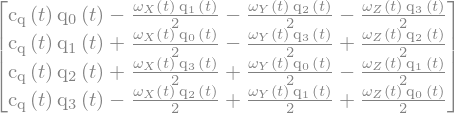

In [3]:
# quaternion kinematics
def Omega(ang_vel):
    return sp.Matrix(
        [
            [0, -ang_vel[0], -ang_vel[1], -ang_vel[2]],
            [ang_vel[0], 0, ang_vel[2], -ang_vel[1]],
            [ang_vel[1], -ang_vel[2], 0, ang_vel[0]],
            [ang_vel[2], ang_vel[1], -ang_vel[0], 0]
        ]
    )

qvec = sp.Matrix(q)
qdot_vec_expr = Omega(I_ang_vel_B)@qvec/2 + cq*qvec
qdotvec = sp.Matrix(q.diff(t))
q_deriv_dict = sp.solve(qdot_vec_expr - qdotvec, qdotvec)
qdot_vec_expr

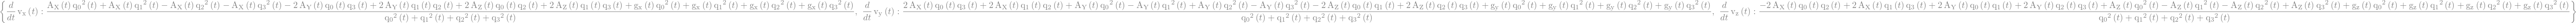

In [4]:
# translational velocity kinematics -- translation_acceleration_due_to_body as input, 
inertial_vel_I_deriv_dict = sp.solve((translation_acceleration_due_to_gravity + translation_acceleration_due_to_body).to_matrix(I).simplify() - sp.Matrix(inertial_vel_I.diff(t)), inertial_vel_I.diff(t))
inertial_vel_I_deriv_dict

In [5]:
kinematics_state_equation_dict = {}
for deriv_dict in inertial_pos_I_deriv_dict, inertial_vel_I_deriv_dict, q_deriv_dict, I_ang_vel_B_deriv_dict:
    kinematics_state_equation_dict.update(deriv_dict)

kinematics_state_extra_dict = {}
kinematics_state_extra_dict[g] = gravity_func
    
sp.Array(kinematics_state_equation_dict.keys())

kinematics_output_dict = {}
kinematics_output_equation_extra_assinments_dict = {}

for state_var in kinematics_state:
    kinematics_output_dict[state_var] = state_var


kinematics_output_equation_extra_assinments_dict[sp.Array((lamda_I, phi_E, h))] = gc2gd
kinematics_output_equation_extra_assinments_dict[lamda_E] = lamda_I - omega_p*t
kinematics_output_dict[lamda_E] = lamda_E
kinematics_output_dict[phi_E] = phi_E
kinematics_output_dict[h] = h

kinematics_output_equation_extra_assinments_dict[planet_fixed_position_x] = sp.Piecewise((px, a<=0.), (phi_E, True)) # phi_E*sp.Heaviside(a, 0) + px*sp.Heaviside(-a, 1)
kinematics_output_equation_extra_assinments_dict[planet_fixed_position_y] = sp.Piecewise((py, a<=0.), (lamda_E, True)) # lamda_E*sp.Heaviside(a, 0) + py*sp.Heaviside(-a, 1)
kinematics_output_equation_extra_assinments_dict[planet_fixed_position_z] = h

kinematics_output_equation_extra_assinments_dict[g] = gravity_func
kinematics_output_equation_extra_assinments_dict[W_NED] = winds_func



In [6]:
a>0

In [7]:
NED_rotation_B = NED.dcm(I) @ I.dcm(B) # equivalent to NED.dcm(B), 
NED_rotation_B_simplified = NED_rotation_B#.simplify() # should be equivalent to LaRC slides [T^{BP}]


kinematics_output_dict[psi] = sp.atan2(NED_rotation_B_simplified[1,0], NED_rotation_B_simplified[0,0])
kinematics_output_dict[theta] = sp.asin(-NED_rotation_B_simplified[2,0]) # LaRC slides seem to disagree with Phillips 2001 by a sign here, cool. 
kinematics_output_dict[phi] = sp.atan2(NED_rotation_B_simplified[2,1], NED_rotation_B_simplified[2,2])


In [8]:
B.ang_vel_in(I) + I.ang_vel_in(G) - B.ang_vel_in(G)

In [9]:
kinematics_output_equation_extra_assinments_dict[density] = density_func
kinematics_output_equation_extra_assinments_dict[speed_of_sound] = speed_of_sound_func
kinematics_output_equation_extra_assinments_dict[viscosity] = viscosity_func

kinematics_output_dict[density] = density
kinematics_output_dict[speed_of_sound] = speed_of_sound
kinematics_output_dict[viscosity] = viscosity

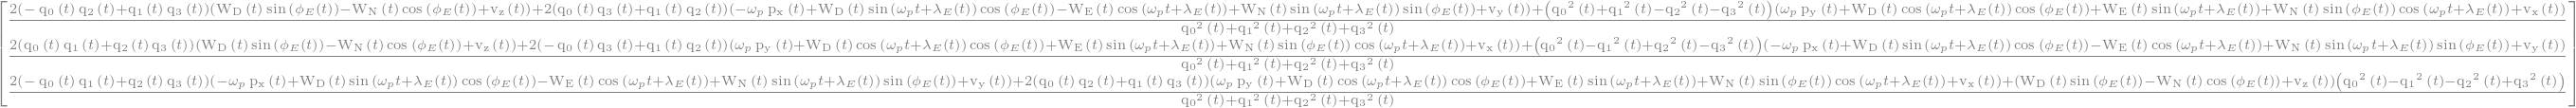

In [10]:
B_cm.v1pt_theory(I0, G, I)
local_wind = W_N*NED.x + W_E*NED.y + W_D*NED.z
body_wind = B_cm.vel(G) - local_wind
body_wind_I = body_wind.to_matrix(I).simplify()

body_wind_B = B.dcm(I).simplify()@body_wind_I
body_wind_B_simplified = body_wind_B.simplify()
# for key, val in zip(airspeed_in_B, body_wind_B_simplified):
#     kinematics_output_dict[key] = val
body_wind_B_simplified

In [11]:
V_T_simp = (body_wind.magnitude()**2).simplify()
kinematics_output_dict[V_T] = sp.sqrt(V_T_simp*sp.Heaviside(V_T_simp)) # sp.Piecewise((sp.sqrt(V_T_simp), V_T_simp>0.), (0., True))
kinematics_output_dict[alpha] = sp.atan2(body_wind_B_simplified[2], body_wind_B_simplified[0])
kinematics_output_dict[beta] = sp.asin(sp.Piecewise((1., (body_wind_B_simplified[1]/kinematics_output_dict[V_T])>1.0), (-1., (body_wind_B_simplified[1]/kinematics_output_dict[V_T])<-1.0), (body_wind_B_simplified[1]/kinematics_output_dict[V_T], kinematics_output_dict[V_T]>0.), (0., True)))

In [12]:
G_ang_vel_B_expr_dict = sp.solve(B.ang_vel_in(G).to_matrix(B) - sp.Matrix(G_ang_vel_B), G_ang_vel_B)
kinematics_output_dict.update(G_ang_vel_B_expr_dict)

In [13]:
V_NED_expr_dict = sp.solve(B_cm.vel(G).to_matrix(NED) - sp.Matrix(V_NED), V_NED)
kinematics_output_dict.update(V_NED_expr_dict)

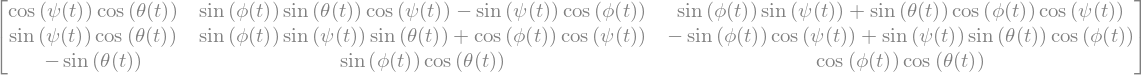

In [14]:
B2 = NED.orientnew('B2', 'Body', [psi, theta, phi], '321')
G_rotation_B = G.dcm(B2).simplify() # should be equivalent to LaRC slides [T^{BP}] at t=0, and taking into account ECI --> NED frames
# LaRC provides a formula that seems to be the special case of Phillips 2001 for q0**2  > q1**2, q2**2, q3**2, with some sign flips
# I'll stick with LaRC slides, but we should be aware of it based on

# trying .T, (8:58)
# could try transposing the quat -> psi theta phi instead? No, this one makes sense to me.
# could also try flipping sign to match Phillips? but that should be the same due to double cover of SO(3)
# I bet there was just a typo on e_4 as first element? order is correct for e_0 to be half_root_... so trying that (9:35), 
# this worked

half_root_trace_plus_1 = sp.sqrt(G_rotation_B.trace()+1)/2
quaternion_from_spec = sp.Array([
    half_root_trace_plus_1,
    (G_rotation_B[2,1] - G_rotation_B[1,2])/(4*half_root_trace_plus_1),
    (G_rotation_B[0,2] - G_rotation_B[2,0])/(4*half_root_trace_plus_1),
    (G_rotation_B[1,0] - G_rotation_B[0,1])/(4*half_root_trace_plus_1),
    
])
quaternion_from_euler_dict = sp.solve(quaternion_from_spec- q, q)
inertial_vel_from_relative_vel_NED_dict = sp.solve(B_cm.vel(G).to_matrix(NED) - sp.Matrix(V_NED), inertial_vel_I)
ic_from_gd_dict = {}
ic_from_gd_dict.update(inertial_vel_from_relative_vel_NED_dict)
ic_from_gd_dict.update(quaternion_from_euler_dict)
ic_from_gd = kinematics_state.subs(ic_from_gd_dict)

sp.physics.mechanics.functions.find_dynamicsymbols(quaternion_from_spec)
ic_extra = {}
ic_extra[inertial_pos_I] = gd2gc
ic_from_gd_args = (lamda_E, phi_E, h, V_N, V_E, V_D, psi, theta, phi, omega_X, omega_Y, omega_Z)

NED.dcm(B2) # this is LaRC [T^{BP}], so previous cell is correct

In [15]:
for wind_var in W_NED:
    kinematics_output_dict[wind_var] = wind_var

In [16]:
kinematics_output[-12]

In [17]:
for key in kinematics_output_dict.keys():
    print(key)

p_x(t)
p_y(t)
p_z(t)
v_x(t)
v_y(t)
v_z(t)
q_0(t)
q_1(t)
q_2(t)
q_3(t)
omega_X(t)
omega_Y(t)
omega_Z(t)
lamda_E(t)
phi_E(t)
h(t)
psi(t)
theta(t)
phi(t)
rho(t)
c_s(t)
mu(t)
V_T(t)
alpha(t)
beta(t)
p_B(t)
q_B(t)
r_B(t)
V_N(t)
V_E(t)
V_D(t)
W_N(t)
W_E(t)
W_D(t)


In [18]:
kin_funcs_to_print = [    
    dict(num_name='kinematics_state_function', input_args=sp.Array([t, *kinematics_state, *kinematics_input]), 
        sym_expr=kinematics_state.diff(t).subs(kinematics_state_equation_dict),
        extra_assignments=kinematics_state_extra_dict ),
        
    dict(num_name='ic_from_geodetic', input_args=sp.Array([t, *ic_from_gd_args]), 
        sym_expr=ic_from_gd,
        extra_assignments=ic_extra, ),
    
    dict(num_name='kinematics_output_function', input_args=sp.Array([t, *kinematics_state]), 
        sym_expr=kinematics_output.subs(kinematics_output_dict),
        extra_assignments=kinematics_output_equation_extra_assinments_dict, ),
]

In [19]:
def staticfy_expressions(expr):
    dyn_syms = list(sp.physics.mechanics.functions.find_dynamicsymbols(expr))
    dynamic_to_static = {}
    for sym in dyn_syms:
        if (len(sym.args) == 1) and sym.args[0] == t:
            dynamic_to_static[sym] = sp.symbols(sym.__class__.__name__)
    
    if len(dynamic_to_static) == 0:
        return expr
    
    new_expr = expr.subs(dynamic_to_static)
    
    if (sp.Function in expr.__class__.__mro__) and hasattr(expr, 'shape'):
        new_expr.shape = expr.shape
    
    return new_expr

def process_funcs_to_print(funcs_to_print):
    code_print_params = []
    for funcs_to_print_dict in funcs_to_print:
        extras_dict = {} #funcs_to_print_dict['extra_assignments'].copy()
        for key,val in funcs_to_print_dict['extra_assignments'].items():
            #print(key, val)
            static_key = staticfy_expressions(key)
            static_val = staticfy_expressions(val)
            extras_dict[static_key] = static_val
        funcs_to_print_dict['extra_assignments'] = extras_dict
        funcs_to_print_dict['input_args'] = staticfy_expressions(funcs_to_print_dict['input_args'])
        funcs_to_print_dict['sym_expr'] = staticfy_expressions(funcs_to_print_dict['sym_expr'])

        tot_size = 1
        if hasattr(funcs_to_print_dict['sym_expr'], 'shape'):
            raveled_shape = funcs_to_print_dict['sym_expr'].shape
            for dim in raveled_shape:
                tot_size = tot_size*dim
            funcs_to_print_dict['sym_expr'] = funcs_to_print_dict['sym_expr'].reshape(tot_size).tolist()

        cse_out = sp.cse(funcs_to_print_dict['sym_expr'], order='none')
        cse_subs = {k:v for k,v in cse_out[0]}
        funcs_to_print_dict['extra_assignments'].update(cse_subs)

        if tot_size > 1:
            funcs_to_print_dict['sym_expr'] = sp.Array(cse_out[1]).reshape(*raveled_shape)
        else:
            funcs_to_print_dict['sym_expr'] = cse_out[1][0]

        code_print_params.append( (funcs_to_print_dict['num_name'], funcs_to_print_dict['input_args'], funcs_to_print_dict['sym_expr'], funcs_to_print_dict['extra_assignments']) )
    return code_print_params

In [20]:
static_kinematics_function_modules = {}
for key in kinematics_function_modules:
    static_kinematics_function_modules[key.func] = kinematics_function_modules[key]

kin_code_print_params = process_funcs_to_print(kin_funcs_to_print)
kin_printer = sympy_fixes.ModuleNumPyPrinter(
    for_class=True,
    function_modules=static_kinematics_function_modules,# function_names=func_names,
    constant_modules={var: 'self' for var in kinematics_parameters}, #constant_names={var: var. for var in kinematics_parameters}
)
kin_evaluator = sympy_fixes.ModulePrinter(kin_printer)
kin_code = kin_evaluator.codeprint(
    (kin_code_print_params[:])
)
with open('kinematics.py', "w") as f:
    f.write(kin_code)

In [21]:
m = symbols('m') 
Ixx, Iyy, Izz, Ixy, Iyz, Ixz = inertia_symbols = \
    symbols('I_xx, I_yy, I_zz, I_xy, I_yz, I_xz')

com_x, com_y, com_z = com_pos = sp.Array(sp.symbols('x_com y_com z_com'))
mrc_x, mrc_y, mrc_z = mrc_pos = sp.Array(sp.symbols('x_mrc y_mrc z_mrc'))
S_A, a_l, b_l, c_l, d_l = sp.symbols('S_A a_l b_l c_l d_l') # reference area; reference directional, lateral, longitudinal lengths; Reynolds number reference length
ref_lengths = np.array([a_l, c_l, b_l])

dynamics_constants = (m, 
                   Ixx, Iyy, Izz, Ixy, Iyz, Ixz,
                   com_x, com_y, com_z,
                   mrc_x, mrc_y, mrc_z,
                   S_A, a_l, b_l, c_l, d_l,)
# Free-stream Frame, velocity along F.x

# Wind frame, freestream wind in -W.x direction -- potentially 
W = vector.frame.ReferenceFrame('W') # Fs.orientnew('Ws', 'Body', [sigma, 0, 0], '123')
# Stability frame, Sf.x and Sf.z in same plane as B.x, B.z
Sf = W.orientnew('Sf', 'Body', [-beta, 0, 0], '312')
Bw = Sf.orientnew('Bw', 'Body', [alpha, 0, 0], '231') # Body frame relative to wind


# D, S, L = aero_forces = sp.Array(dynamicsymbols('D S L')) # aero Drag, Lift, Side forces
aero_forces = sp.Array(dynamicsymbols('F_ax F_ay F_az')) # aero body fixed forces
Lcal, Mcal, Ncal = aero_moments = sp.Array(dynamicsymbols('Lcal Mcal Ncal')) # aero Roll, Pitch, Yaw moment

# total aero coefficients
CD, CS, CL = total_aero_force_coeffs = sp.Array(dynamicsymbols('CD CS CL')) # static aero forces
CLcal, CMcal, CNcal = total_aero_moment_coeffs = sp.Array(dynamicsymbols('CLcal CMcal CNcal')) # static aero moments
# CLcal_s, CMcal_s, CNcal_s = transformed_static_aero_moment_coeffs = sp.Array(dynamicsymbols('CLcal_s CMcal_s CNcal_s')) # static aero moments
Cp, Cq, Cr = total_aero_damping_coeffs = sp.Array(dynamicsymbols('Cp Cq Cr')) # dynamic aero moments

Fx, Fy, Fz = tot_body_fixed_forces_var = sp.Array(dynamicsymbols('F_x F_y F_z')) # total body-fixed forces
Mx, My, Mz = tot_body_fixed_moments_var = sp.Array(dynamicsymbols('M_x M_y M_z')) # total body-fixed moments


# base aero coefficients
CDb, CSb, CLb = base_aero_force_coeffs =  np.array(dynamicsymbols('CD_b CS_b CL_b'))
CLcalb, CMcalb, CNcalb = base_aero_moment_coeffs = np.array(dynamicsymbols('CLcal_b CMcal_b CNcal_b'))
Cpb, Cqb, Crb = base_aero_damping_coeffs = np.array(dynamicsymbols('Cp_b Cq_b Cr_b'))


qbar, mach, reynolds = sp.symbols('qbar Ma Re')
base_aero_coeffs_func = sp.Function('base_aero_coeffs')(alpha, beta, mach, reynolds)
base_aero_coeffs_func.shape = (9,)

# extra aero coefficients -- inputs, can be used to model aerodynamic control surfaces or do configuration management on aero (i.e., add wings or tail to base vehicle)
# assumed to use same references areas/lengths as base, and moments are about same MRC
CDe, CSe, CLe = input_aero_force_coeffs = np.array(dynamicsymbols('CD_e CS_e CL_e'))
CLcale, CMcale, CNcale = input_aero_moment_coeffs = np.array(dynamicsymbols('CLcal_e CMcal_e CNcal_e'))
Cpe, Cqe, Cre = input_aero_damping_coeffs = np.array(dynamicsymbols('Cp_e Cq_e Cr_e'))

base_aero_coeffs = sp.Array([
    *base_aero_force_coeffs,
    *base_aero_moment_coeffs,
    *base_aero_damping_coeffs,
])

input_aero_coeffs = sp.Array([
    *input_aero_force_coeffs,
    *input_aero_moment_coeffs,
    *input_aero_damping_coeffs,
])

# extra forces and torques/moments in body-fixed coordinates (moments about center of mass)
Phix, Phiy, Phiz = input_forces = sp.Array(dynamicsymbols('Phi_x Phi_y Phi_z'))
taux, tauy, tauz = input_moments = sp.Array(dynamicsymbols('tau_x tau_y tau_z'))

input_forces_moments = sp.Array([*input_forces, *input_moments])

# aero_forces = -D*W.x - L*W.z + S*W.y
# aero_moments = Lcal*B.x + Mcal*B.y + Ncal*B.z



qbar_expr = V_T**2*density/2
mach_expr = V_T/speed_of_sound
Re_expr = V_T*d_l*density/viscosity

total_aero_force_coeffs = base_aero_force_coeffs + input_aero_force_coeffs
total_aero_damping_coeffs_mrc = base_aero_damping_coeffs + input_aero_damping_coeffs
total_static_aero_moment_coeffs_mrc = base_aero_moment_coeffs + input_aero_moment_coeffs 
total_aero_moment_coeffs_mrc = total_static_aero_moment_coeffs_mrc + total_aero_damping_coeffs_mrc*ref_lengths*G_ang_vel_B*sp.Piecewise((1/(2*V_T), V_T> 0.), (0., True))

dynamics_input = sp.Array([
    t,
    *kinematics_output,
    *input_forces,
    *input_moments,
    *input_aero_force_coeffs,
    *input_aero_moment_coeffs,
    *input_aero_damping_coeffs,
])

dynamics_output = sp.Array([*inertial_acc_B, *I_ang_acc_B])
dynamics_output_dict = {}



dynamics_output_extra_dict = {}
dynamics_output_extra_dict[qbar] = qbar_expr
dynamics_output_extra_dict[mach] = mach_expr
dynamics_output_extra_dict[reynolds] = Re_expr
dynamics_output_extra_dict[base_aero_coeffs] = base_aero_coeffs_func


# in general, moment coefficient = static coefficient + ((dynamic coefficient * angular rate * ref length) / (2 * true airspeed))
# LaRC slides show an extra half factor on dynamic term, but NESC description doesn't have that... coefficients can be re-normalized
# so just need to clarify the definition

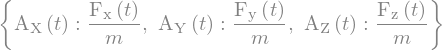

In [22]:
inertial_acc_B_dict = sp.solve(m*inertial_acc_B - tot_body_fixed_forces_var, inertial_acc_B) # this assumes constant mass
dynamics_output_dict.update(inertial_acc_B_dict)
inertial_acc_B_dict

In [23]:
II = inertia(Bw, Ixx, Iyy, Izz, -Ixy, -Iyz, -Ixz)
Bw_ang_vel_I = omega_X*Bw.x + omega_Y*Bw.y + omega_Z*Bw.z
Bw_ang_acc_I = alpha_X*Bw.x + alpha_Y*Bw.y + alpha_Z*Bw.z
inertial_ang_acc_B_dict = sp.solve(sp.Array((II.dot(Bw_ang_acc_I) + Bw_ang_vel_I.cross(II.dot(Bw_ang_vel_I))).to_matrix(Bw))[:, 0] - tot_body_fixed_moments_var, I_ang_acc_B)
dynamics_output_dict.update(inertial_ang_acc_B_dict)


In [24]:
print(', '.join(('self.' + var.__str__() for var in dynamics_constants)))

kinematics_state.shape
kinematics_input.shape
kinematics_output.shape

dynamics_input.shape
dynamics_output.shape

self.m, self.I_xx, self.I_yy, self.I_zz, self.I_xy, self.I_yz, self.I_xz, self.x_com, self.y_com, self.z_com, self.x_mrc, self.y_mrc, self.z_mrc, self.S_A, self.a_l, self.b_l, self.c_l, self.d_l


In [25]:
# total_aero_force_coeffs = base_aero_force_coeffs + input_aero_force_coeffs
# total_aero_damping_coeffs_mrc = base_aero_damping_coeffs + input_aero_damping_coeffs
# total_static_aero_moment_coeffs_mrc = base_aero_moment_coeffs + input_aero_moment_coeffs 
# total_aero_moment_coeffs_mrc = total_static_aero_moment_coeffs_mrc + total_aero_damping_coeffs_mrc*ref_lengths*G_ang_vel_B/(2*V_T)

body_unit_vecs = np.array([Bw.x, Bw.y, Bw.z])
wind_unit_vecs = np.array([W.x, W.y, W.z])
total_aero_force_coeffs_vec = -total_aero_force_coeffs[0]*W.x + total_aero_force_coeffs[1]*W.y -total_aero_force_coeffs[2]*W.z
total_aero_moment_coeffs_mrc_vec = np.sum(total_aero_moment_coeffs_mrc*body_unit_vecs)

mrc_to_com = np.array(com_pos - mrc_pos)
mrc_to_com_vec = np.sum(mrc_to_com*body_unit_vecs) #(com_x-mrc_x)*Bw.x + (com_y-mrc_y)*Bw.y + (com_z-mrc_z)*Bw.z


#mrc_to_com_vec.cross(total_aero_force_coeffs_vec).express(Bw).simplify()
total_aero_moment_coeffs_com = np.array(total_aero_moment_coeffs_mrc - np.array((total_aero_force_coeffs_vec.cross(mrc_to_com_vec)).to_matrix(Bw)).squeeze()/ref_lengths)#.simplify()
total_aero_moments_com_expr = qbar*S_A*total_aero_moment_coeffs_com*ref_lengths
total_aero_forces_expr = qbar*S_A*np.array(total_aero_force_coeffs_vec.to_matrix(Bw)).squeeze()

total_aero_forces_moments_syms = sp.Array([*aero_forces, *aero_moments])
total_aero_forces_moments_expr = sp.Array([*total_aero_forces_expr, *total_aero_moments_com_expr])
total_aero_forces_moments_func = sp.Function('tot_aero_forces_moments')(qbar, V_T, alpha, beta, *G_ang_vel_B, *base_aero_coeffs, *input_aero_coeffs)
total_aero_forces_moments_func.shape = (6,)


dynamics_output_extra_dict[total_aero_forces_moments_syms] = total_aero_forces_moments_func

tot_forces_moments_syms = sp.Array([*tot_body_fixed_forces_var, *tot_body_fixed_moments_var])
tot_forces_moments_expr = total_aero_forces_moments_syms + input_forces_moments

dynamics_output_extra_dict[tot_forces_moments_syms] = tot_forces_moments_expr

In [26]:
# I don't think this does anything.
# for key in dynamics_output_dict:
#     dynamics_output_dict[key] = dynamics_output_dict[key].simplify()

In [27]:
total_aero_forces_moments_func.args

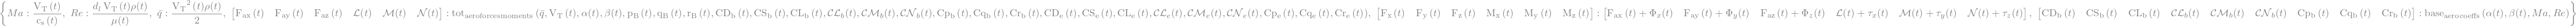

In [28]:
dynamics_output_extra_dict

In [29]:
dyn_funcs_to_print = [
    dict(num_name=total_aero_forces_moments_func.func.__name__, input_args=sp.Array(total_aero_forces_moments_func.args), 
        sym_expr=total_aero_forces_moments_expr,
        extra_assignments={}, ),
    
    dict(num_name='dynamics_output_function', input_args=dynamics_input, 
        sym_expr=dynamics_output.subs(dynamics_output_dict),
        extra_assignments=dynamics_output_extra_dict, ),
]

In [30]:
dyn_printer = sympy_fixes.ModuleNumPyPrinter(
    for_class=True, function_modules={total_aero_forces_moments_func.func: 'self', base_aero_coeffs_func.func: 'self',},
#     function_modules=func_modules, function_names=func_names,
    constant_modules={var: 'self' for var in dynamics_constants}, #constant_names={var: var. for var in kinematics_parameters}
)
dyn_evaluator = sympy_fixes.ModulePrinter(dyn_printer)

dyn_code_print_params = process_funcs_to_print(dyn_funcs_to_print)

dyn_code = dyn_evaluator.codeprint(
    (dyn_code_print_params[:])
)
with open('dynamics.py', "w") as f:
    f.write(dyn_code)
print(dyn_code)

import self
import numpy


def tot_aero_forces_moments(self, qbar, V_T, alpha, beta, p_B, q_B, r_B, CD_b, CS_b, CL_b, CLcal_b, CMcal_b, CNcal_b, Cp_b, Cq_b, Cr_b, CD_e, CS_e, CL_e, CLcal_e, CMcal_e, CNcal_e, Cp_e, Cq_e, Cr_e):
    x0 = -CL_b - CL_e
    x1 = numpy.sin(alpha)
    x2 = numpy.cos(alpha)
    x3 = numpy.cos(beta)
    x4 = -CD_b - CD_e
    x5 = x3*x4
    x6 = CS_b + CS_e
    x7 = numpy.sin(beta)
    x8 = x6*x7
    x9 = -x0*x1 + x2*x5 - x2*x8
    x10 = self.S_A*qbar
    x11 = x3*x6 + x4*x7
    x12 = x0*x2 + x1*x5 - x1*x8
    x13 = self.z_com - self.z_mrc
    x14 = self.y_com - self.y_mrc
    x15 = numpy.select([numpy.greater(V_T, 0.0)], [(1/2)/V_T], default=0.0)
    x16 = self.x_com - self.x_mrc
    return (numpy.array([x10*x9, x10*x11, x10*x12, self.a_l*x10*(CLcal_b + CLcal_e + self.a_l*p_B*x15*(Cp_b + Cp_e) - (x11*x13 - x12*x14)/self.a_l), self.c_l*x10*(CMcal_b + CMcal_e + self.c_l*q_B*x15*(Cq_b + Cq_e) - (x12*x16 - x13*x9)/self.c_l), self.b_l*x10*(CNcal_b + CNcal_e + self.b